### Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing nearul network architecture proven to work on problems similar to our own.
2. Can leverage a working nearul network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

### Downloading and becoming one with the data

In [1]:
# Get data (10% of food classes from food101)
import zipfile

# downlaod
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downlaoded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-08 11:59:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.68.48, 142.250.188.240, 142.251.40.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.68.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip'

10_food_classes_10_ 100%[===================>] 160.74M  4.15MB/s    in 38s     

2023-07-08 12:00:35 (4.22 MB/s) - '10_food_classes_10_percent.zip' saved [168546183/168546183]



In [1]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirname, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 10 directori

### Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [2]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing iamges:")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical")

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Training Images:
Found 750 images belonging to 10 classes.
Testing iamges:
Found 2500 images belonging to 10 classes.


### Seting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbeacks:
* Tracking experiments with the TensorBord callbeacks
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [3]:
# Create TensorBoard callback (functionized becouse we need to create a new one for each model)
from tensorflow.keras.callbacks import TensorBoard
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to {log_dir}")
    return tensorboard_callback

>**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like.
The `log_dir` parameter we have created above is only one option

### Creating models using TensorFlow Hub
In the past we have used TensorFlow to create our own models layer by layer from scratch.
Now we are going to do a similar process, except the majority of our model's layers are going to come from TensorFLow Hub.
We can access pretrained model on: https://tfhub.dev

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [4]:
# Lets compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [5]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
tf.config.set_visible_devices([], 'GPU')

In [6]:
# Lets make a create_model() fuction to create a model from a URL

def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a keras sequential model with it.

    Args:
        model_url(str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, defoult 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractior
        layer and Dense output layer with num_classes output neurons.
    """

    # Download the pretrained model and save it as a kears layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,# freeze the already learned patterns
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,))
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

In [7]:
# create resnet mdoel
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [8]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [9]:
# Lets fit our resnet model to the data (10 percent )
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=6,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to tensorflow_hub/resnet50V2/20230708-191501
Epoch 1/6
24/24 [==============================] - 92s 4s/step - loss: 1.9297 - accuracy: 0.3507 - val_loss: 1.2051 - val_accuracy: 0.6216
Epoch 2/6
24/24 [==============================] - 145s 6s/step - loss: 0.9263 - accuracy: 0.7307 - val_loss: 0.8743 - val_accuracy: 0.7188
Epoch 3/6
24/24 [==============================] - 130s 6s/step - loss: 0.6282 - accuracy: 0.8227 - val_loss: 0.7634 - val_accuracy: 0.7548
Epoch 4/6
24/24 [==============================] - 133s 6s/step - loss: 0.4732 - accuracy: 0.8893 - val_loss: 0.6983 - val_accuracy: 0.7756
Epoch 5/6
24/24 [==============================] - 124s 5s/step - loss: 0.3783 - accuracy: 0.9213 - val_loss: 0.6616 - val_accuracy: 0.7828
Epoch 6/6
24/24 [==============================] - 128s 6s/step - loss: 0.3094 - accuracy: 0.9440 - val_loss: 0.6604 - val_accuracy: 0.7800


Wow!
That is incredible. Our transfer learning feature extractor model out perform ALL of the previous models we built by hand.. (substantially) and in a quicker training time and with only 10% of the training examples.

In [10]:
# Lets creayte a function to plot our loss curves
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need...
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
        history: TensorFlow History object.
        
    Return:
        Plot of training/validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
#     plot loss

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
#     plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

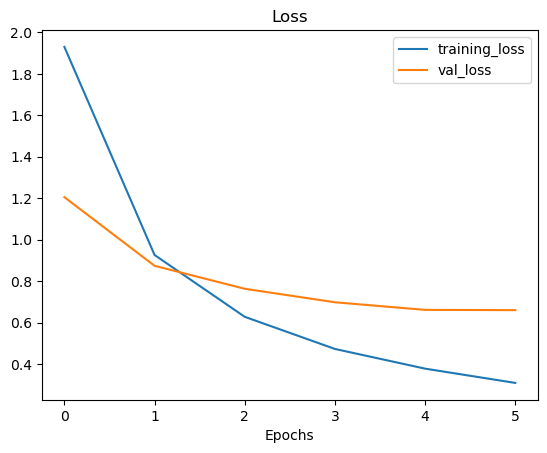

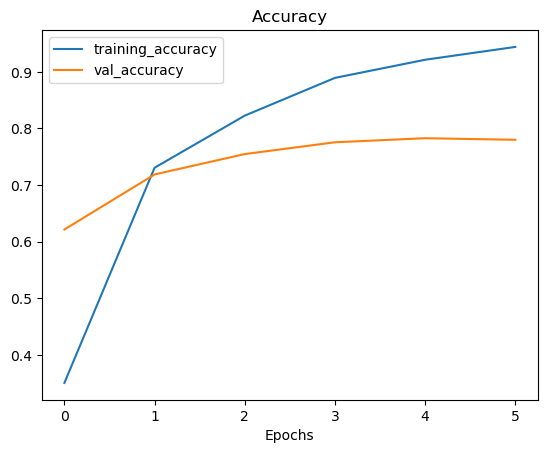

In [11]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [21]:
# Create EfficinetNetB0 feature extractor model
efficiant_model = create_model(model_url=efficientnet_url,
                              num_classes=train_data_10_percent.num_classes)
# Compile EfficinetNet model
efficiant_model.compile(loss="categorical_crossentropy",
                       optimizer="adam",
                       metrics=['accuracy'])

# fit EfficientNet model to 10% of training data 
efficiant_history = efficiant_model.fit(train_data_10_percent,
                                       epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                       validation_data=test_data,
                                       validation_steps=len(test_data),
                                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                             experiment_name="efficientnetb0")])

Saving TensorBoard log files to tensorflow_hub/efficientnetb0/20230709-205841
Epoch 1/5
24/24 [==============================] - 32s 1s/step - loss: 1.8402 - accuracy: 0.4307 - val_loss: 1.3103 - val_accuracy: 0.7224
Epoch 2/5
24/24 [==============================] - 29s 1s/step - loss: 1.0800 - accuracy: 0.7493 - val_loss: 0.8792 - val_accuracy: 0.8192
Epoch 3/5
24/24 [==============================] - 30s 1s/step - loss: 0.7693 - accuracy: 0.8240 - val_loss: 0.7092 - val_accuracy: 0.8404
Epoch 4/5
24/24 [==============================] - 30s 1s/step - loss: 0.6137 - accuracy: 0.8507 - val_loss: 0.6191 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 30s 1s/step - loss: 0.5189 - accuracy: 0.8787 - val_loss: 0.5620 - val_accuracy: 0.8628


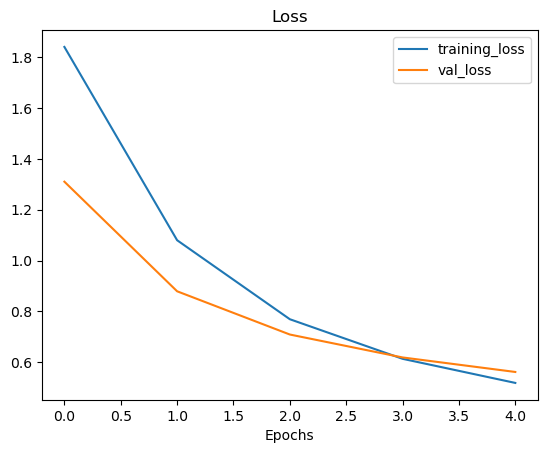

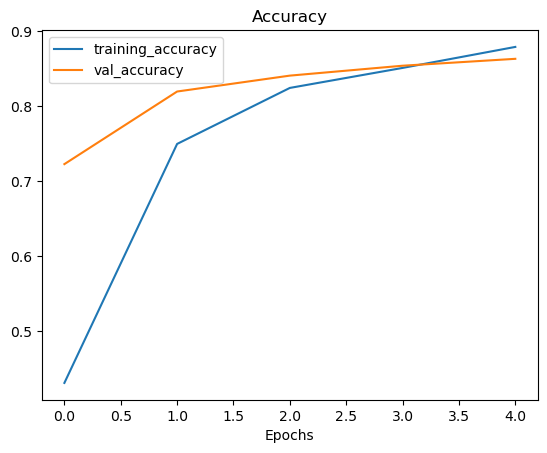

In [22]:
plot_loss_curves(efficiant_history)

In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [25]:
efficiant_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


### Different types of transfer learning
* **"As is" transfer learning -** using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)

* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g 1000 classes -> 10 classes food)

* **"Fine-tuning"** transfer learning - use prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)